In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import torch
import torch.utils.data

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [75]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [76]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
import sys
sys.path.insert(0,'C:/git/vision/references/detection/')

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [5]:
##制作数据集

class BatteryDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class ???
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [93]:
dataset = BatteryDataset('C:/Users/yanzliu/Desktop/img_segmentation/')

### fintuning from a pretrained model (for try)

In [138]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [130]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (frame) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### add mask layer

In [6]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
model = get_instance_segmentation_model(2)

### helper function for data argumentation

In [8]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### putting everything together

In [64]:
# use our dataset and defined transformations
dataset = BatteryDataset('C:/Users/yanzliu/Desktop/img_segmentation/', get_transform(train=True))
dataset_test = BatteryDataset('C:/Users/yanzliu/Desktop/img_segmentation/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-5])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-5:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [65]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

##先warm

In [247]:
# let's train it for 10 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 30 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

C:\Users\yanzliu\Anaconda3\lib\site-packages\torch\nn\functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/55]  eta: 0:01:14  lr: 0.000097  loss: 0.0819 (0.0819)  loss_classifier: 0.0048 (0.0048)  loss_box_reg: 0.0084 (0.0084)  loss_mask: 0.0650 (0.0650)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0030 (0.0030)  time: 1.3570  data: 0.0900  max mem: 2650
Epoch: [0]  [10/55]  eta: 0:00:59  lr: 0.001022  loss: 0.1150 (0.2005)  loss_classifier: 0.0141 (0.0147)  loss_box_reg: 0.0262 (0.0257)  loss_mask: 0.0667 (0.1506)  loss_objectness: 0.0021 (0.0023)  loss_rpn_box_reg: 0.0060 (0.0072)  time: 1.3138  data: 0.1112  max mem: 2650
Epoch: [0]  [20/55]  eta: 0:00:46  lr: 0.001948  loss: 0.1252 (0.1792)  loss_classifier: 0.0143 (0.0144)  loss_box_reg: 0.0262 (0.0281)  loss_mask: 0.0733 (0.1257)  loss_objectness: 0.0021 (0.0044)  loss_rpn_box_reg: 0.0053 (0.0066)  time: 1.3171  data: 0.0928  max mem: 2650
Epoch: [0]  [30/55]  eta: 0:00:32  lr: 0.002873  loss: 0.1282 (0.1657)  loss_classifier: 0.0137 (0.0141)  loss_box_reg: 0.0287 (0.0295)  loss_mask: 0.0733 (0.1087)  loss_ob

### show dataset test graph

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

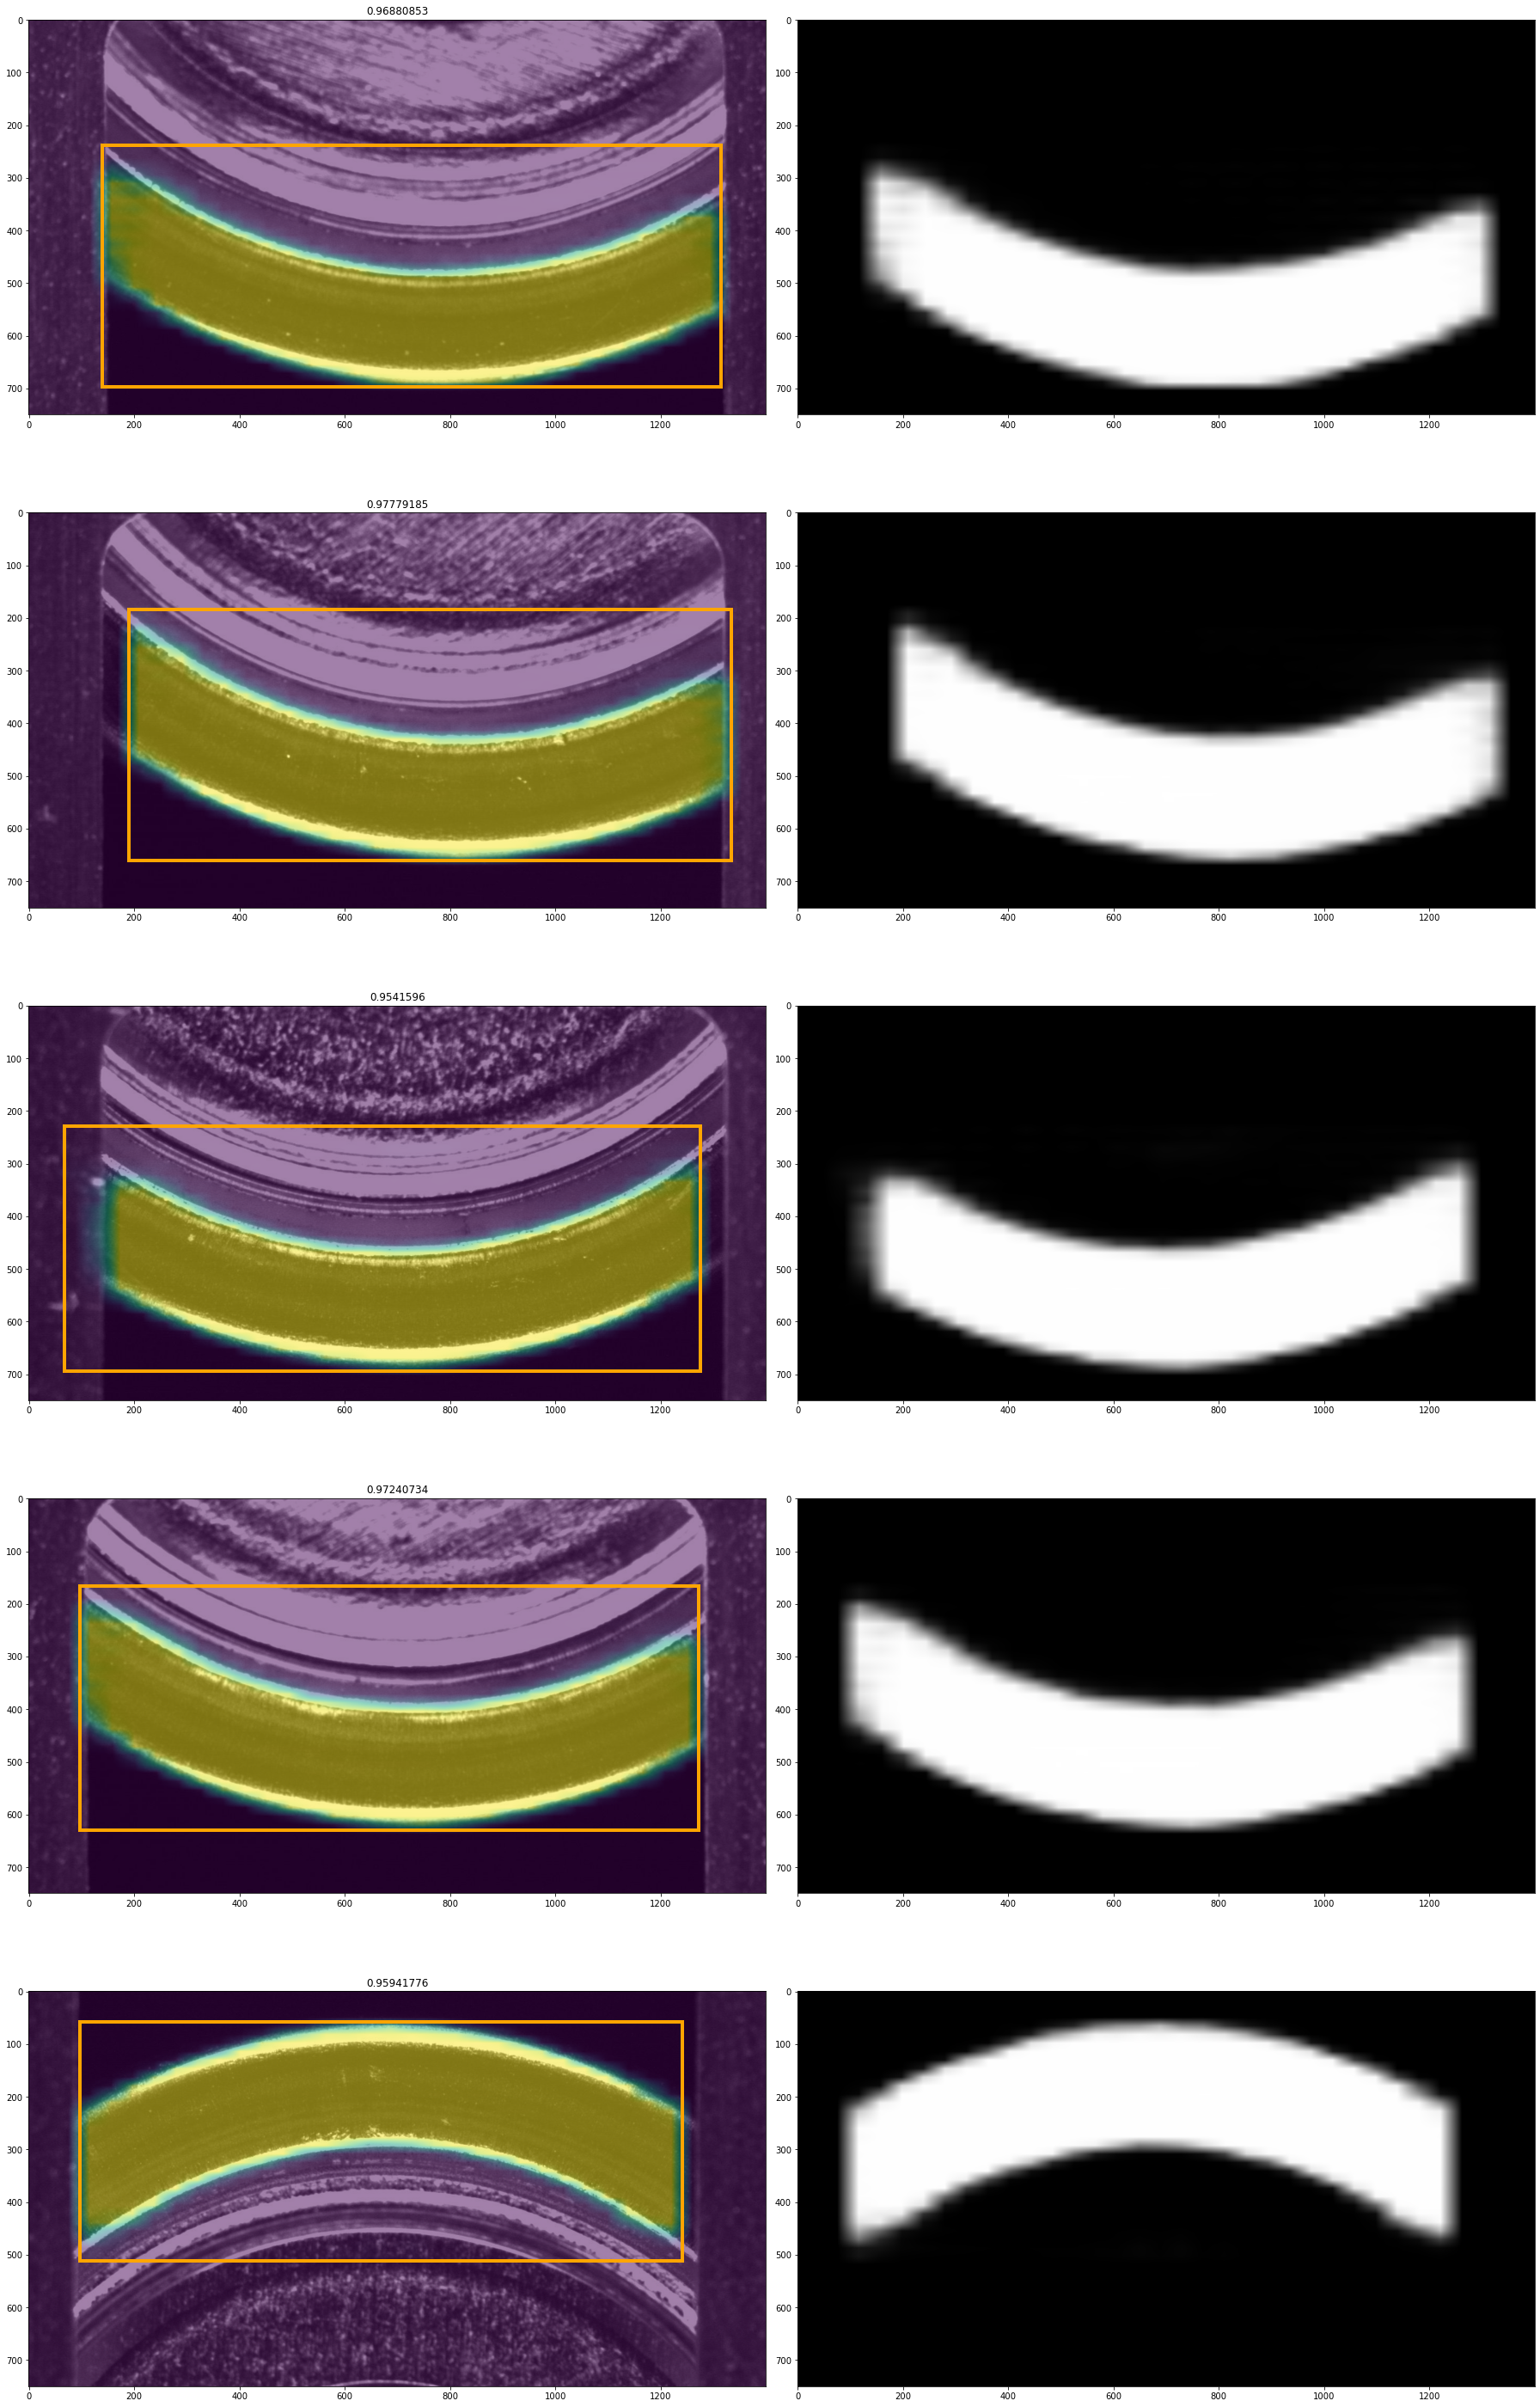

In [244]:
plt.figure(figsize=(25,40))

for idx in range(0, len(dataset_test)*2, 2):
    img,_ = dataset_test[int(idx/2)]
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    plt.subplot(5, 2, idx+1)
    plt.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    rect_co = prediction[0]['boxes'].cpu().numpy()[0]
    x = rect_co[1]
    y = rect_co[0]
    width = rect_co[3] - rect_co[1]
    height = rect_co[2] - rect_co[0]
    plt.gca().add_patch(plt.Rectangle(xy=(y, x), width=height, height=width, fill=False, linewidth=4, edgecolor='orange'))
    plt.imshow(prediction[0]['masks'][0,0].mul(255).byte().cpu().numpy(), alpha=0.5)
    plt.title(prediction[0]['scores'][0].cpu().numpy())
    
    plt.subplot(5, 2, idx+2)
    img = prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()
    img = np.expand_dims(img, axis=2)
    img = np.concatenate((img, img, img), axis=2)
    plt.imshow(img)

_ = plt.tight_layout()